In [1]:
from fastai.vision import *
from fastai.utils.mem import *

In [2]:
from adastop import AdaStop

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt')]

In [4]:
path_img = path / 'images'
path_lbl = path / 'labels'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f01020.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06390.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f01830.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f02340_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01230_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009150_P.png')]

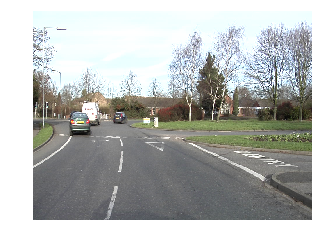

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

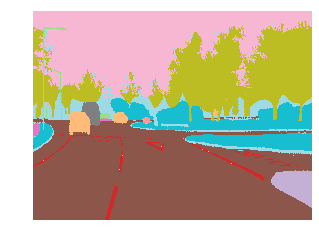

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
size = src_size//2

In [18]:
free = gpu_mem_get_free_no_cache()
if free > 8200: bs = 8
else: bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [19]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs).normalize(imagenet_stats))

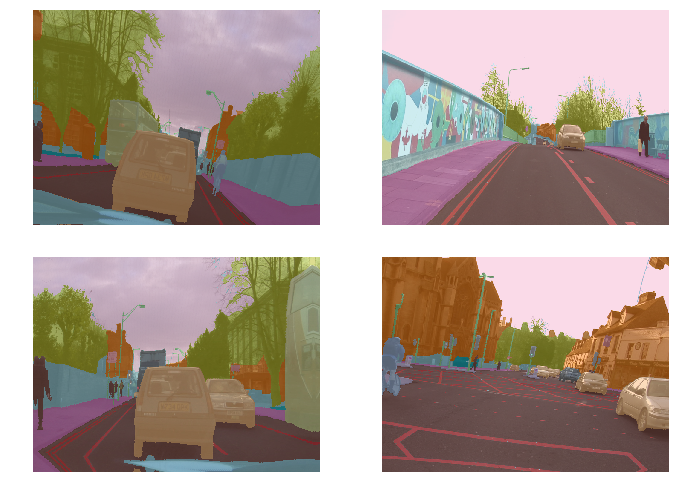

In [21]:
data.show_batch(2, figsize=(10, 7))

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()        

In [19]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2)

In [21]:
learn.opt_func = AdaStop

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


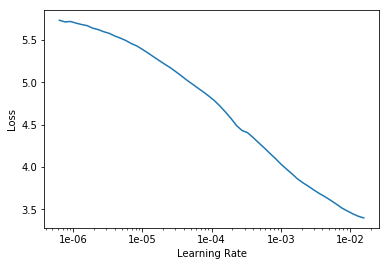

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr = 3e-4

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.738611,1.890925,0.553484,00:56
1,1.426261,0.911026,0.792244,00:52
2,0.969627,0.721682,0.826348,00:52
3,0.749829,0.636424,0.823704,00:52
4,0.665931,0.555630,0.841329,00:52
5,0.587005,0.451075,0.874806,00:52
6,0.562140,0.445411,0.873175,00:52
7,0.504888,0.410174,0.880421,00:52
8,0.473379,0.459179,0.866100,00:52
9,0.418877,0.330262,0.902519,00:52


In [25]:
learn.save('stage-1')

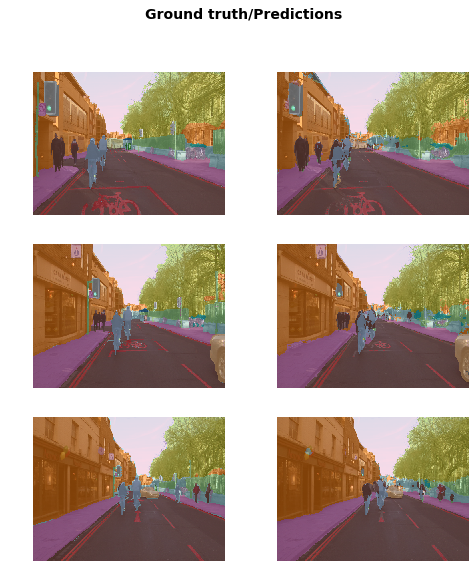

In [26]:
learn.show_results(rows=3, figsize=(8,9))

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


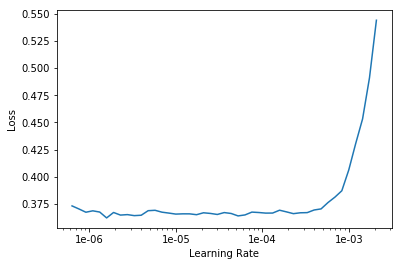

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(12, slice(3e-5, lr/5), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.367274,0.328664,0.902209,00:54
1,0.363517,0.326309,0.901782,00:54
2,0.353935,0.328390,0.900216,00:54
3,0.346904,0.319121,0.904495,00:54
4,0.343433,0.323810,0.901955,00:54
5,0.341844,0.316581,0.909898,00:54
6,0.347018,0.347805,0.894499,00:54
7,0.343373,0.364780,0.894477,00:54
8,0.331556,0.312229,0.905529,00:54
9,0.315693,0.330781,0.902159,00:54


In [30]:
learn.save('stage-2');

In [31]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [23]:
size = src_size

In [24]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 15679MB of GPU RAM free


In [25]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [26]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2)
learn.opt_func = AdaStop

In [27]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/jupyter/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/jupyter/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


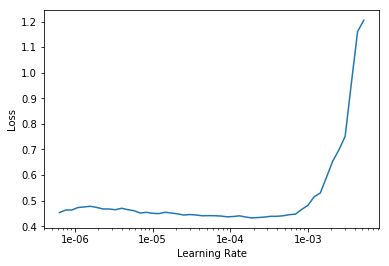

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
lr = 4e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(3e-5, lr/5))

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.show_results(rows=3, figsize=(10,10))